## Example to perform common edge analysis with VAR-LiNGAM
This notebook explains how to calculates the bootstrap probability of multiple datasets for time series data.  
The algorithm covered here is VARLiNGAM.

## Import necessary packages

In [1]:
import lingam
import numpy as np
import pandas as pd
from lingam.utils import make_dot
from lingam.utils import get_common_edge_probabilities, print_common_edge_directions, make_dot_for_nan_probability_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print([np.__version__, pd.__version__, lingam.__version__])

['1.26.4', '2.2.3', '1.10.0']


## Test data
We create test data consisting of 5 variables.

In [2]:
import numpy as np
import pandas as pd

def get_sample_data_var_lingam(
    n_features,
    n_samples,
    T_spurious=20,
    expon=1.5,
    noise_scale_min=0.5,
    noise_scale_max=1.5,
    sparsity_B0=0.4,
    sparsity_B1=0.4,
    random_state=None
):
    """
    Generate synthetic time series data based on a VAR-LiNGAM model.

    Parameters
    ----------
    n_features : int
        Number of variables (features) in the time series.
    n_samples : int
        Number of time steps (samples) to generate after removing spurious steps.
    T_spurious : int, optional (default=20)
        Number of initial time steps to discard for stabilization (warm-up period).
    expon : float, optional (default=1.5)
        Exponent used to transform Gaussian noise into non-Gaussian noise.
        Values > 1 increase skewness and kurtosis.
    noise_scale_min : float, optional (default=0.5)
        Minimum value for the standard deviation of noise per feature.
    noise_scale_max : float, optional (default=1.5)
        Maximum value for the standard deviation of noise per feature.
    sparsity_B0 : float between 0 and 1, optional (default=0.4)
        Probability that each element in the B0 matrix is non-zero.
        Controls the sparsity of instantaneous causal connections.
    sparsity_B1 : float between 0 and 1, optional (default=0.4)
        Probability that each element in the B1 matrix is non-zero.
        Controls the sparsity of lagged causal connections.
    random_state : int or None, optional
        Seed for random number generation to ensure reproducibility.

    Returns
    -------
    df : pandas.DataFrame
        A DataFrame of shape (n_samples, n_features) containing the generated time series data.
        Columns are named as 'x0', 'x1', ..., 'x{n_features-1}'.
    """
    np.random.seed(random_state)
    
    # B0: Structure at time t
    value = np.random.uniform(low=0.05, high=0.5, size=(n_features, n_features))
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    B0 = np.multiply(value, sign)
    B0 = np.multiply(B0, np.random.binomial(1, sparsity_B0, size=(n_features, n_features)))
    B0 = np.tril(B0, k=-1)

    # B1: Structure at time t-1
    value = np.random.uniform(low=0.05, high=0.5, size=(n_features, n_features))
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    B1 = np.multiply(value, sign)
    B1 = np.multiply(B1, np.random.binomial(1, sparsity_B1, size=(n_features, n_features)))
    M1 = np.dot(np.linalg.inv(np.eye(n_features) - B0), B1)

    # Noise generation
    ee = np.empty((n_features, n_samples + T_spurious))
    for i in range(n_features):
        ee[i, :] = np.random.normal(size=(1, n_samples + T_spurious))
        ee[i, :] = np.multiply(np.sign(ee[i, :]), abs(ee[i, :]) ** expon)
        ee[i, :] = ee[i, :] - np.mean(ee[i, :])
        ee[i, :] = ee[i, :] / np.std(ee[i, :])

    # Adjusting the standard deviation of noise
    std_e = np.random.uniform(low=noise_scale_min, high=noise_scale_max, size=(n_features,))
    nn = np.dot(np.dot(np.linalg.inv(np.eye(n_features) - B0), np.diag(std_e)), ee)

    # Generating time series data
    xx = np.zeros((n_features, n_samples + T_spurious))
    xx[:, 0] = np.random.normal(size=(n_features,))
    for t in range(1, n_samples + T_spurious):
        xx[:, t] = np.dot(M1, xx[:, t - 1]) + nn[:, t]

    # Exclude spurious periods
    data = xx[:, T_spurious + 1 : T_spurious + n_samples]
    df = pd.DataFrame(data.T, columns=[f"x{i}" for i in range(n_features)])

    return df


In [3]:
X_list = []
for i in range(5):
    X = get_sample_data_var_lingam(
        n_features=5,
        n_samples=1000,
        T_spurious=20,
        expon=1.5,
        noise_scale_min=-1.0,
        noise_scale_max=1.0,
        sparsity_B0=0.4+(i/100),
        sparsity_B1=0.4+(i/100),
        random_state=i
    )
    X_list.append(X)

## Causal discovery in time series data.
To calculate common edges, we bootstrap with VAR-LiNGAM and summarize the results in a list.

In [4]:
np.random.seed(0)
n_sampling = 100
model = lingam.VARLiNGAM()
results = [model.bootstrap(X, n_sampling) for X in X_list]
labels = [f"{col}(t-{l})" if l > 0 else f"{col}(t)" for l in range(len(model.adjacency_matrices_)) for col in X_list[0].columns]

To display the list of edges, calculate the probability matrix of common edges.

In [5]:
cep = get_common_edge_probabilities(results)
print_common_edge_directions(cep, labels=labels)

x0(t) <--- x2(t-1) (100.0%)
x4(t) <--- x2(t-1) (100.0%)
x3(t) <--- x3(t-1) (100.0%)
x2(t) <--- x4(t-1) (100.0%)
x3(t) <--- x4(t-1) (100.0%)
x2(t) <--- x1(t-1) (99.0%)
x0(t) <--- x0(t-1) (90.2%)
x0(t) <--- x3(t-1) (85.1%)
x3(t) <--- x1(t-1) (55.1%)
x4(t) <--- x0(t-1) (54.2%)
x2(t) <--- x2(t-1) (30.3%)
x3(t) <--- x2(t-1) (19.1%)
x1(t) <--- x4(t-1) (18.4%)
x4(t) <--- x3(t-1) (7.5%)
x3(t) <--- x1(t) (1.7%)


The causal graph of common edges is as follows. The values of the edges are the occurrence probabilities.

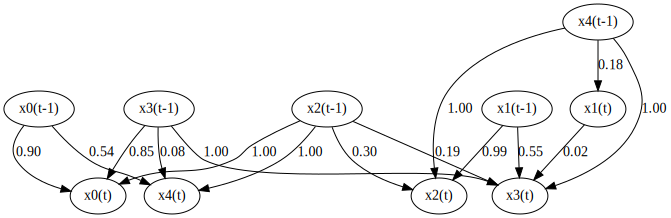

In [6]:
make_dot(cep[0], ignore_shape=True, labels=labels)

You can hide edges based on probability values.

In [7]:
print_common_edge_directions(cep, labels=labels, confidence_level=0.6)

x0(t) <--- x2(t-1) (100.0%)
x4(t) <--- x2(t-1) (100.0%)
x3(t) <--- x3(t-1) (100.0%)
x2(t) <--- x4(t-1) (100.0%)
x3(t) <--- x4(t-1) (100.0%)
x2(t) <--- x1(t-1) (99.0%)
x0(t) <--- x0(t-1) (90.2%)
x0(t) <--- x3(t-1) (85.1%)


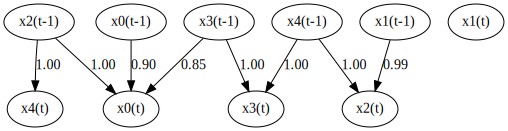

In [8]:
make_dot(cep[0], ignore_shape=True, labels=labels, lower_limit=0.6)